<a href="https://colab.research.google.com/github/Jelh23/heat-mass-transfer/blob/main/Heat_Transfer_Transient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##WARNING

*   Use RUN ALL, every time
*   Check results for λₙ in Wolfram



In [ ]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

from scipy.optimize import fsolve
from scipy.special import j0, j1, jn_zeros  # Bessel functions
from scipy.optimize import root_scalar

# Plane Wall

## Parameters

In [ ]:
L = 0.02  # Half thickness of the wall (m)
A = 1  # Surface area of one side (m^2)
V = A * 2 * L  # Volume of the wall (m^3), 2L because it's the full thickness

T_inf = 500 + 273.15  # Ambient temperature on both sides (K)
Ti = 20 + 273.15  # Initial temperature of the wall (K)

h = 120  # Convective heat transfer coefficient on both sides (W/m^2K)

k = 110  # Thermal conductivity of the wall (W/m·K)
alpha = 33.9e-6  # Thermal diffusivity of the wall (m^2/s)

t = 7*60  # Time (s)
x = 1  # Position from the center of the wall (meters, m), [-L, L]

rho = 8530  # Density of the material (kg/m^3)
Cp = 380    # Specific heat capacity of the material (J/kg·K)

## Lumped System Check

In [ ]:
A_s_wall = 2 * A  # Both surfaces exposed

Lc_wall = V / A_s_wall
Bi_wall = h * Lc_wall / k

print(f"Lc_wall: {Lc_wall:.4f} m")
print(f"Bi_wall: {Bi_wall:.4f} \n")

if Bi_wall <= 0.1:
    print("Lumped system model is valid for the wall")
else:
    print("Lumped system model is NOT valid for the wall")

Lc_wall: 0.0200 m
Bi_wall: 0.0218 

Lumped system model is valid for the wall


## Biot and Fourier numbers

In [ ]:
Bi = (h * L) / k  # Biot number (dimensionless)
Fo = (alpha * t) / (L**2)  # Fourier number (dimensionless time)

print(f"Biot number (Bi): {Bi}")
print(f"Fourier number (Fo) for time {t} s: {Fo}")

Biot number (Bi): 0.021818181818181816
Fourier number (Fo) for time 420 s: 35.595


## Characteristic equation

In [ ]:
# Function to represent the characteristic equation
def characteristic_eq(lambda_n, Bi):
    return lambda_n * np.tan(lambda_n) - Bi

def solve_lambda_n(Bi, num_eigenvalues=5, tol=1e-6):
    lambda_n_values = []

    # Special case: Bi ≈ 0 ⇒ λ = 0 is a solution
    if np.isclose(Bi, 0.0, atol=tol):
        lambda_n_values.append(0.0)
        num_eigenvalues -= 1

    # Use a good spread of initial guesses to hit each root
    initial_guesses = np.linspace(0.5, num_eigenvalues * np.pi, num_eigenvalues * 2)

    for guess in initial_guesses:
        lambda_n_solution = fsolve(characteristic_eq, guess, args=(Bi,), xtol=1e-10, maxfev=10000)
        lambda_n = lambda_n_solution[0]

        # Filter only valid and distinct roots
        if lambda_n > 0 and not any(np.isclose(lambda_n, val, atol=1e-6) for val in lambda_n_values):
            lambda_n_values.append(lambda_n)

        if len(lambda_n_values) >= num_eigenvalues:
            break

    return np.sort(lambda_n_values)


# Use the Biot number (Bi) calculated earlier
lambda_n_values = solve_lambda_n(Bi)

# Print the results
print("Eigenvalues (lambda_n) for Bi =", Bi)
for i, lambda_n in enumerate(lambda_n_values):
    print(f"lambda_{i+1}: {lambda_n}")

Eigenvalues (lambda_n) for Bi = 0.021818181818181816
lambda_1: 0.1471748059851693
lambda_2: 3.14852220059651
lambda_3: 6.286655847757758
lambda_4: 9.427092369285518
lambda_5: 12.568106608537144


**Check with Wolfram:** x * tan(x) = Bi

## Factor Aₙ

In [ ]:
# Function to calculate A_n for each lambda_n
def calculate_An(lambda_n_values):
    An_values = []
    for lambda_n in lambda_n_values:
        An = (4 * np.sin(lambda_n)) / (2 * lambda_n + np.sin(2 * lambda_n))  # An formula
        An_values.append(An)
    return An_values

# Calculate A_n for each lambda_n
An_values = calculate_An(lambda_n_values)

# Print only the A_n values
print("Corresponding A_n values:")
for i, An in enumerate(An_values):
    print(f"A_{i+1}: {An}")

Corresponding A_n values:
A_1: 1.0036087072708104
A_2: -0.004392076057810914
A_3: 0.0011034861344210946
A_4: -0.0004908912101305267
A_5: 0.00027621559972825904


## Dimensionless temperature θₙ

In [ ]:
# Function to calculate dimensionless temperature theta_n
def calculate_theta_n(An_values, lambda_n_values, Fo, x, L):
    theta_n_values = []
    for An, lambda_n in zip(An_values, lambda_n_values):
        theta_n = An * np.exp(-(lambda_n**2) * Fo) * np.cos(lambda_n * x / L)  # theta_n formula
        theta_n_values.append(theta_n)
    return theta_n_values

# Calculate dimensionless temperature theta_n for each n
theta_n_values = calculate_theta_n(An_values, lambda_n_values, Fo, x, L)

# Print individual theta_n values
print("Dimensionless temperature theta_n values:")
for i, theta_n in enumerate(theta_n_values):
    print(f"theta_{i+1}: {theta_n}")

# Calculate the sum of all theta_n values
sum_theta_n = sum(theta_n_values)

# Print the sum of all theta_n values separately
print(f"\nSum of all theta_n values: {sum_theta_n}")

Dimensionless temperature theta_n values:
theta_1: 0.22061691963097876
theta_2: -2.348991770923832e-156
theta_3: 0.0
theta_4: -0.0
theta_5: 0.0

Sum of all theta_n values: 0.22061691963097876


## Solutions table

In [ ]:
# Function to display the results in a table format
def display_results_table(lambda_n_values, An_values, theta_n_values):
    # Prepare the data for the table
    table_data = {
        'n': np.arange(1, len(lambda_n_values) + 1),
        'lambda_n': [round(val, 6) for val in lambda_n_values],
        'A_n': [round(val, 6) for val in An_values],
        'theta_n': [round(val, 6) for val in theta_n_values]
    }

    # Create a DataFrame for better visualization
    df = pd.DataFrame(table_data)

    # Calculate the sum of all theta_n values and add it as a row in the table
    sum_theta_n = round(sum(theta_n_values), 6)
    df.loc[len(df)] = ['Sum', '', '', sum_theta_n]

    # Display the table
    print("\nResults Table:")
    print(df)

# Display results with table
display_results_table(lambda_n_values, An_values, theta_n_values)


# Function to calculate the total temperature T(x,t) based on the sum of theta_n
def calculate_temperature(T_inf, Ti, theta_n_values):
    # Sum of all theta_n values
    sum_theta_n = sum(theta_n_values)
    # Total temperature equation: T = T_inf + sum(theta_n) * (Ti - T_inf)
    T_total = T_inf + sum_theta_n * (Ti - T_inf)
    return round(T_total, 2)

# Calculate the total temperature at x
T_total = calculate_temperature(T_inf, Ti, theta_n_values)
# Convert the total temperature to Celsius
T_total_C = T_total - 273.15

# Display the result
print(f"\nCalculated Temperature at x = {x} m: {T_total} K")
print(f"Calculated Temperature at x = {x} m: {T_total_C:.2f} °C")


Results Table:
     n   lambda_n       A_n   theta_n
0    1   0.147175  1.003609  0.220617
1    2   3.148522 -0.004392 -0.000000
2    3   6.286656  0.001103  0.000000
3    4   9.427092 -0.000491 -0.000000
4    5  12.568107  0.000276  0.000000
5  Sum                       0.220617

Calculated Temperature at x = 1 m: 667.25 K
Calculated Temperature at x = 1 m: 394.10 °C


## Heat Transfer Q

In [ ]:
lambda_1 = lambda_n_values[0]  # First eigenvalue
A1 = An_values[0]  # First An


# Calculate QMax
QMax = rho * V * Cp * (Ti - T_inf)

# Calculate theta_0,wall
theta0_wall = A1 * np.exp(-lambda_1**2 * Fo)

# Calculate heat transfer Q
Q = QMax * (1 - (theta0_wall * np.sin(lambda_1) / lambda_1))

# Display the results in scientific notation
print(f"QMax: {QMax:.3e} J")
print(f"theta0_wall: {theta0_wall:.3e}")
print(f"\nHeat Transfer (Q): {Q:.3e} J")

if Q > 0:
    print(f"The wall expelled {Q:.2e} J of heat.")
else:
    print(f"The wall absorbed {-Q:.2e} J of heat.")

QMax: -6.223e+07 J
theta0_wall: 4.642e-01

Heat Transfer (Q): -3.345e+07 J
The wall absorbed 3.34e+07 J of heat.


## Graph

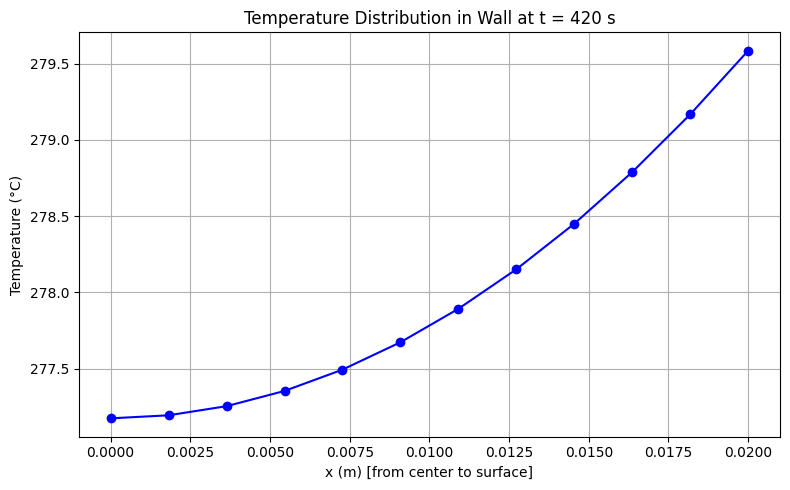

In [ ]:
# Function to calculate theta_n at a given x
def calculate_theta_n_wall(An_values, lambda_n_values, Fo, x, L):
    theta_n_values = []
    for An, lambda_n in zip(An_values, lambda_n_values):
        theta_n = An * np.exp(-(lambda_n**2) * Fo) * np.cos(lambda_n * x / L)
        theta_n_values.append(theta_n)
    return sum(theta_n_values)

# Generate spatial points from center (x=0) to surface (x=L)
x_points = np.linspace(0, L, 12)  # 12 points inside wall
theta_profile = [calculate_theta_n_wall(An_values, lambda_n_values, Fo, x, L) for x in x_points]
T_profile = [T_inf + theta * (Ti - T_inf) for theta in theta_profile]

# Convert to Celsius for plotting (optional)
T_profile_C = [T - 273.15 for T in T_profile]

# Plotting
plt.figure(figsize=(8, 5))
plt.plot(x_points, T_profile_C, marker='o', linestyle='-', color='blue')
plt.title("Temperature Distribution in Wall at t = {:.0f} s".format(t))
plt.xlabel("x (m) [from center to surface]")
plt.ylabel("Temperature (°C)")
plt.grid(True)
plt.tight_layout()
plt.show()

# Long Cylinder

## Parameters

In [ ]:
r0 = 0.1  # Outer radius (m)
L = 2  # Length of the cylinder (m)
V = math.pi * (r0**2) * L  # Volume of the cylinder (m^3)

T_inf = 50 + 273.15  # Ambient temperature (K)
Ti = 400 + 273.15  # Initial temperature of the cylinder (K)

h = 200  # Convective heat transfer coefficient (W/m^2K)

k = 40  # Thermal conductivity of the cylinder (W/m·K)
alpha = 1.0e-5  # Thermal diffusivity of the cylinder (m^2/s)

t = 1200  # Time (s)
r = 0.05  # Position from the center of the cylinder (meters, m), [0, r0]

rho = 7800  # Density of the material (kg/m^3)
Cp = 500    # Specific heat capacity of the material (J/kg·K)

## Lumped System Check

In [ ]:
A_s_cyl = 2 * math.pi * r0 * L + 2 * math.pi * r0**2  # Lateral + two ends

Lc_cyl = V / A_s_cyl
Bi_cyl = h * Lc_cyl / k

print(f"Lc_cyl: {Lc_cyl:.4f} m")
print(f"Bi_cyl: {Bi_cyl:.4f} \n")

if Bi_cyl <= 0.1:
    print("Lumped system model is valid for the cylinder")
else:
    print("Lumped system model is NOT valid for the cylinder")


Lc_cyl: 0.0476 m
Bi_cyl: 0.2381 

Lumped system model is NOT valid for the cylinder


## Biot and Fourier numbers

In [ ]:
Bi = (h * r0) / k  # Biot number (dimensionless)
Fo = (alpha * t) / (r0**2)  # Fourier number (dimensionless time)

print(f"Biot number (Bi): {Bi}")
print(f"Fourier number (Fo) for time {t} s: {Fo}")

Biot number (Bi): 0.5
Fourier number (Fo) for time 1200 s: 1.1999999999999997


## Characteristic equation

In [ ]:
# Characteristic equation for a cylinder
def characteristic_eq_cyl(lambda_n, Bi):
    return lambda_n * j1(lambda_n) / j0(lambda_n) - Bi

def solve_lambda_n_cyl(Bi, num_eigenvalues=5, tol=1e-6):
    lambda_n_values = []

    # Special case: Bi ≈ 0 ⇒ λ = 0 is a solution
    if np.isclose(Bi, 0.0, atol=tol):
        lambda_n_values.append(0.0)
        num_eigenvalues -= 1  # reduce how many more roots we need

    # Get more than needed to provide safe bracketing
    j0_zeros = jn_zeros(0, num_eigenvalues + 5)

    # Create brackets between J0 zeros to avoid asymptotes
    brackets = [(1e-6, j0_zeros[0] - 1e-3)]  # Start very close to 0
    for i in range(len(j0_zeros) - 1):
        a = j0_zeros[i] + 1e-3
        b = j0_zeros[i + 1] - 1e-3
        brackets.append((a, b))

    for a, b in brackets:
        try:
            sol = root_scalar(characteristic_eq_cyl, args=(Bi,), bracket=[a, b], method='brentq')
            if sol.converged:
                root = sol.root
                if not any(np.isclose(root, val, atol=1e-6) for val in lambda_n_values):
                    lambda_n_values.append(root)
                    if len(lambda_n_values) >= num_eigenvalues:
                        break
        except ValueError:
            continue

    return np.sort(lambda_n_values)


# Use the Biot number (Bi) calculated earlier
lambda_n_values_cyl = solve_lambda_n_cyl(Bi)

# Print the results
print("Eigenvalues (lambda_n) for Bi =", Bi)
for i, lambda_n in enumerate(lambda_n_values_cyl):
    print(f"lambda_{i+1}: {lambda_n}")

Eigenvalues (lambda_n) for Bi = 0.5
lambda_1: 0.9407705639492654
lambda_2: 3.9593711850125315
lambda_3: 7.086380847961729
lambda_4: 10.22245839663869
lambda_5: 13.361148893395523


**Check with Wolfram:** λ * (BesselJ[1, λ] / BesselJ[0, λ]) = Bi

## Factor Aₙ

In [ ]:
# Function to calculate A_n for the cylinder using the given expression
def calculate_An_cyl(lambda_n_values):
    An_values = []
    for lambda_n in lambda_n_values:
        numerator = j1(lambda_n)
        denominator = j0(lambda_n)**2 + j1(lambda_n)**2
        An = (2 / lambda_n) * (numerator / denominator)
        An_values.append(An)
    return An_values

# Calculate A_n for each lambda_n
An_values_cyl = calculate_An_cyl(lambda_n_values_cyl)

# Print A_n values
print("Corresponding A_n values for cylinder:")
for i, An in enumerate(An_values_cyl):
    print(f"A_{i+1}_cyl: {An}")

Corresponding A_n values for cylinder:
A_1_cyl: 1.114254631482523
A_2_cyl: -0.15715959718524825
A_3_cyl: 0.06618979991886696
A_4_cyl: -0.03827763129269145
A_5_cyl: 0.025635227377255234


## Dimensionless temperature θₙ

In [ ]:
# Function to calculate dimensionless temperature theta_n for a cylinder
def calculate_theta_n_cyl(An_values, lambda_n_values, Fo, r, r0):
    theta_n_values = []
    for An, lambda_n in zip(An_values, lambda_n_values):
        theta_n = An * np.exp(-(lambda_n**2) * Fo) * j0(lambda_n * r / r0)
        theta_n_values.append(theta_n)
    return theta_n_values

# Example usage:
# r: position at which to evaluate temperature (in same units as r0)
# r0: radius of the cylinder
theta_n_values_cyl = calculate_theta_n_cyl(An_values_cyl, lambda_n_values_cyl, Fo, r, r0)

# Print each theta_n value
print("Dimensionless temperature theta_n values (cylinder):")
for i, theta_n in enumerate(theta_n_values_cyl):
    print(f"theta_{i+1}_cyl: {theta_n}")

# Sum of theta_n terms
sum_theta_n_cyl = sum(theta_n_values_cyl)
print(f"\nSum of all theta_n values (cylinder): {sum_theta_n_cyl}")

Dimensionless temperature theta_n values (cylinder):
theta_1_cyl: 0.36422870197284085
theta_2_cyl: -2.5039651719092953e-10
theta_3_cyl: -1.7232777065347197e-28
theta_4_cyl: 1.8660860907678226e-57
theta_5_cyl: 6.6743046581528684e-96

Sum of all theta_n values (cylinder): 0.3642287017224443


##Solutions table

In [ ]:
# Function to display the results table (Cylinder version)
def display_results_table_cyl(lambda_n_values, An_values, theta_n_values):
    table_data = {
        'n': np.arange(1, len(lambda_n_values) + 1),
        'lambda_n_cyl': [round(val, 6) for val in lambda_n_values],
        'A_n_cyl': [round(val, 6) for val in An_values],
        'theta_n_cyl': [round(val, 6) for val in theta_n_values]
    }

    df = pd.DataFrame(table_data)

    # Add the sum of theta_n at the bottom
    sum_theta_n_cyl = round(sum(theta_n_values), 6)
    df.loc[len(df)] = ['Sum', '', '', sum_theta_n_cyl]

    # Display the table
    print("\nResults Table for Cylinder:")
    print(df)

# Display results
display_results_table_cyl(lambda_n_values_cyl, An_values_cyl, theta_n_values_cyl)

# Function to calculate the total temperature T(r,t) for cylinder
def calculate_temperature_cyl(T_inf, Ti, theta_n_values):
    sum_theta_n_cyl = sum(theta_n_values)
    T_total_cyl = T_inf + sum_theta_n_cyl * (Ti - T_inf)
    return round(T_total_cyl, 2)

# Calculate total temperature at r
T_total_cyl = calculate_temperature_cyl(T_inf, Ti, theta_n_values_cyl)
T_total_C_cyl = T_total_cyl - 273.15

# Display temperature at r
print(f"\nCalculated Temperature at r = {r} m: {T_total_cyl} K")
print(f"Calculated Temperature at r = {r} m: {T_total_C_cyl:.2f} °C")


Results Table for Cylinder:
     n lambda_n_cyl   A_n_cyl  theta_n_cyl
0    1     0.940771  1.114255     0.364229
1    2     3.959371  -0.15716    -0.000000
2    3     7.086381   0.06619    -0.000000
3    4    10.222458 -0.038278     0.000000
4    5    13.361149  0.025635     0.000000
5  Sum                            0.364229

Calculated Temperature at r = 0.05 m: 450.63 K
Calculated Temperature at r = 0.05 m: 177.48 °C


##Heat Transfer Q

In [ ]:
# First eigenvalue and A_n
lambda_1_cyl = lambda_n_values_cyl[0]
A1_cyl = An_values_cyl[0]

# QMax
QMax_cyl = rho * V * Cp * (Ti - T_inf)

# theta_0 at center
theta0_cyl = A1_cyl * np.exp(-lambda_1_cyl**2 * Fo)

# Heat transfer Q for cylinder
Q_cyl = QMax_cyl * (1 - (2 * theta0_cyl * j1(lambda_1_cyl) / lambda_1_cyl))

# Display results
print(f"QMax (cylinder): {QMax_cyl:.3e} J")
print(f"theta0_cyl (center): {theta0_cyl:.3e}")
print(f"\nHeat Transfer Q (cylinder): {Q_cyl:.3e} J")

if Q_cyl > 0:
    print(f"The cylinder expelled {Q_cyl:.2e} J of heat.")
else:
    print(f"The cylinder absorbed {-Q_cyl:.2e} J of heat.")

QMax (cylinder): 8.577e+07 J
theta0_cyl (center): 3.852e-01

Heat Transfer Q (cylinder): 5.625e+07 J
The cylinder expelled 5.62e+07 J of heat.


# Sphere

##Parameters

In [ ]:
r0 = 0.1  # Outer radius of the sphere (m)
V = (4 / 3) * math.pi * r0**3  # Volume of the sphere (m^3)

T_inf = 50 + 273.15  # Ambient temperature (K)
Ti = 400 + 273.15    # Initial temperature of the sphere (K)

h = 200        # Convective heat transfer coefficient (W/m^2·K)
k = 40         # Thermal conductivity of the sphere (W/m·K)
alpha = 1.0e-5 # Thermal diffusivity (m^2/s)

t = 1200     # Time (s)
r = 0.05     # Radial position from center of sphere (m), [0, r0]

rho = 7800  # Density (kg/m^3)
Cp = 500    # Specific heat capacity (J/kg·K)

## Lumped System Check

In [ ]:
A_s_sph = 4 * math.pi * r0**2

Lc_sph = V / A_s_sph
Bi_sph = h * Lc_sph / k

print(f"Lc_sph: {Lc_sph:.4f} m")
print(f"Bi_sph: {Bi_sph:.4f} \n")

if Bi_sph <= 0.1:
    print("Lumped system model is valid for the sphere")
else:
    print("Lumped system model is NOT valid for the sphere")


Lc_sph: 0.0333 m
Bi_sph: 0.1667 

Lumped system model is NOT valid for the sphere


##Biot and Fourier numbers

In [ ]:
Bi = (h * r0) / k  # Biot number (dimensionless)
Fo = (alpha * t) / (r0**2)  # Fourier number (dimensionless time)

print(f"Biot number (Bi): {Bi}")
print(f"Fourier number (Fo) for time {t} s: {Fo}")

Biot number (Bi): 0.5
Fourier number (Fo) for time 1200 s: 1.1999999999999997


##Characteristic equation

In [ ]:
# Characteristic equation for a sphere
def characteristic_eq_sph(lambda_n, Bi):
    return 1 - lambda_n / np.tan(lambda_n) - Bi

# Solver for lambda_n values for a sphere
def solve_lambda_n_sph(Bi, num_eigenvalues=5, tol=1e-6):
    lambda_n_values = []

    # Special case: Bi ≈ 0 ⇒ λ = 0 is a solution
    if np.isclose(Bi, 0.0, atol=tol):
        lambda_n_values.append(0.0)
        num_eigenvalues -= 1

    # Brackets between asymptotes of tan: near multiples of π
    brackets = [(n * np.pi + 1e-3, (n + 1) * np.pi - 1e-3) for n in range(num_eigenvalues * 2)]

    for a, b in brackets:
        try:
            sol = root_scalar(characteristic_eq_sph, args=(Bi,), bracket=[a, b], method='brentq')
            if sol.converged:
                root = sol.root
                if not any(np.isclose(root, val, atol=1e-6) for val in lambda_n_values):
                    lambda_n_values.append(root)
                    if len(lambda_n_values) >= num_eigenvalues:
                        break
        except ValueError:
            continue

    return np.sort(lambda_n_values)


# Use the previously calculated Bi
lambda_n_values_sph = solve_lambda_n_sph(Bi)

# Display the eigenvalues
print("Eigenvalues (lambda_n) for sphere, Bi =", Bi)
for i, lambda_n in enumerate(lambda_n_values_sph):
    print(f"lambda_{i+1}: {lambda_n}")

Eigenvalues (lambda_n) for sphere, Bi = 0.5
lambda_1: 1.1655611852071996
lambda_2: 4.6042167772003095
lambda_3: 7.789883751144573
lambda_4: 10.94994364854116
lambda_5: 14.101725133565873


**Check with Wolfram:** 1 - x * cot(x) = Bi

## Factor Aₙ

In [ ]:
# Function to calculate A_n for the sphere using the given expression
def calculate_An_sph(lambda_n_values):
    An_values = []
    for lambda_n in lambda_n_values:
        numerator = 4 * (np.sin(lambda_n) - lambda_n * np.cos(lambda_n))
        denominator = 2 * lambda_n - np.sin(2 * lambda_n)
        An = numerator / denominator
        An_values.append(An)
    return An_values

# Calculate A_n for each lambda_n
An_values_sph = calculate_An_sph(lambda_n_values_sph)

# Print A_n values
print("Corresponding A_n values for sphere:")
for i, An in enumerate(An_values_sph):
    print(f"A_{i+1}_sph: {An}")


Corresponding A_n values for sphere:
A_1_sph: 1.1441063423067408
A_2_sph: -0.22107631686001622
A_3_sph: 0.12916793089026068
A_4_sph: -0.09161084260217016
A_5_sph: 0.07104718948169331


## Dimensionless temperature θₙ

In [ ]:
# Function to calculate dimensionless temperature theta_n for a sphere
def calculate_theta_n_sph(An_values, lambda_n_values, Fo, r, r0):
    theta_n_values = []
    for An, lambda_n in zip(An_values, lambda_n_values):
        if r == 0:
            # At the center of the sphere, sin(x)/x → 1
            spatial_part = 1
        else:
            spatial_part = np.sin(lambda_n * r / r0) / (lambda_n * r / r0)

        theta_n = An * np.exp(-(lambda_n**2) * Fo) * spatial_part
        theta_n_values.append(theta_n)
    return theta_n_values

# Calculate theta_n for the sphere
theta_n_values_sph = calculate_theta_n_sph(An_values_sph, lambda_n_values_sph, Fo, r, r0)

# Print theta_n values
print("Dimensionless temperature theta_n values for sphere:")
for i, theta_n in enumerate(theta_n_values_sph):
    print(f"theta_{i+1}_sph: {theta_n}")

# Total dimensionless temperature
sum_theta_n_sph = sum(theta_n_values_sph)
print(f"\nSum of all theta_n values (sphere): {sum_theta_n_sph}")


Dimensionless temperature theta_n values for sphere:
theta_1_sph: 0.21163839144532776
theta_2_sph: -6.402229033480396e-13
theta_3_sph: -5.382503000433104e-34
theta_4_sph: 3.942630395915911e-65
theta_5_sph: 1.618442915011877e-106

Sum of all theta_n values (sphere): 0.21163839144468755


## Solutions table

In [ ]:
# Function to display the results table (Sphere version)
def display_results_table_sph(lambda_n_values, An_values, theta_n_values):
    table_data = {
        'n': np.arange(1, len(lambda_n_values) + 1),
        'lambda_n_sph': [round(val, 6) for val in lambda_n_values],
        'A_n_sph': [round(val, 6) for val in An_values],
        'theta_n_sph': [round(val, 6) for val in theta_n_values]
    }

    df = pd.DataFrame(table_data)

    # Add the sum of theta_n at the bottom
    sum_theta_n_sph = round(sum(theta_n_values), 6)
    df.loc[len(df)] = ['Sum', '', '', sum_theta_n_sph]

    # Display the table
    print("\nResults Table for Sphere:")
    print(df)

# Display results
display_results_table_sph(lambda_n_values_sph, An_values_sph, theta_n_values_sph)

# Function to calculate the total temperature T(r,t) for sphere
def calculate_temperature_sph(T_inf, Ti, theta_n_values):
    sum_theta_n_sph = sum(theta_n_values)
    T_total_sph = T_inf + sum_theta_n_sph * (Ti - T_inf)
    return round(T_total_sph, 2)

# Calculate total temperature at r
T_total_sph = calculate_temperature_sph(T_inf, Ti, theta_n_values_sph)
T_total_C_sph = T_total_sph - 273.15

# Display temperature at r
print(f"\nCalculated Temperature at r = {r} m: {T_total_sph} K")
print(f"Calculated Temperature at r = {r} m: {T_total_C_sph:.2f} °C")


Results Table for Sphere:
     n lambda_n_sph   A_n_sph  theta_n_sph
0    1     1.165561  1.144106     0.211638
1    2     4.604217 -0.221076    -0.000000
2    3     7.789884  0.129168    -0.000000
3    4    10.949944 -0.091611     0.000000
4    5    14.101725  0.071047     0.000000
5  Sum                            0.211638

Calculated Temperature at r = 0.05 m: 397.22 K
Calculated Temperature at r = 0.05 m: 124.07 °C


## Heat Transfer Q

In [ ]:
# First eigenvalue and A_n for sphere
lambda_1_sph = lambda_n_values_sph[0]
A1_sph = An_values_sph[0]

# QMax for sphere
QMax_sph = rho * V * Cp * (Ti - T_inf)

# theta0_sph at r = 0 (center of the sphere)
theta0_sph = A1_sph * np.exp(-lambda_1_sph**2 * Fo)

# Heat transfer Q for sphere
numerator = np.sin(lambda_1_sph) - lambda_1_sph * np.cos(lambda_1_sph)
Q_sph = QMax_sph * (1 - (3 * theta0_sph * numerator) / (lambda_1_sph**3))

# Display results
print(f"QMax (sphere): {QMax_sph:.3e} J")
print(f"theta0_sph (center): {theta0_sph:.3e}")
print(f"\nHeat Transfer Q (sphere): {Q_sph:.3e} J")

if Q_sph > 0:
    print(f"The sphere expelled {Q_sph:.2e} J of heat.")
else:
    print(f"The sphere absorbed {-Q_sph:.2e} J of heat.")


QMax (sphere): 5.718e+06 J
theta0_sph (center): 2.241e-01

Heat Transfer Q (sphere): 4.602e+06 J
The sphere expelled 4.60e+06 J of heat.
